In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import transforms
import data
from model.unet import U_Net
from model.simple_unet import Simple_Unet
import matplotlib.pyplot as plt
import torch
from torchsummary import summary
import glob
from sklearn.model_selection import train_test_split

/Users/maochenhui/miniforge3/envs/DL/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# model = U_Net()
model = Simple_Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (3, 2302, 1632))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 9, 1152, 832]             252
       BatchNorm2d-2         [-1, 9, 1152, 832]              18
              ReLU-3         [-1, 9, 1152, 832]               0
            Conv2d-4         [-1, 9, 1152, 832]             738
       BatchNorm2d-5         [-1, 9, 1152, 832]              18
              ReLU-6         [-1, 9, 1152, 832]               0
        conv_block-7         [-1, 9, 1152, 832]               0
            Conv2d-8         [-1, 12, 576, 416]             984
       BatchNorm2d-9         [-1, 12, 576, 416]              24
             ReLU-10         [-1, 12, 576, 416]               0
           Conv2d-11         [-1, 12, 576, 416]           1,308
      BatchNorm2d-12         [-1, 12, 576, 416]              24
             ReLU-13         [-1, 12, 576, 416]               0
       conv_block-14         [-1, 12, 5

In [5]:
SCANS_DIR = "input/scans/scans/"
TRUTH_DIR = "input/ground-truth-pixel/ground-truth-pixel/"
scan_files = glob.glob(SCANS_DIR+'*.png')
scan_files = sorted(scan_files)
# scan_files = list(filter(lambda x:"(" not in x, scan_files))
scan_files_dev = scan_files[:400]

scan_files_test = scan_files[400:]
truth_files = glob.glob(TRUTH_DIR+'*.png')
truth_files = sorted(truth_files)
# truth_files = list(filter(lambda x:"(" not in x, truth_files))

scan_files_train, scan_files_val, truth_files_train, truth_files_val = train_test_split(scan_files_dev, truth_files, test_size=0.3)

In [6]:
from torch.utils.data import DataLoader
train_data = data.CustomDataset(scans = scan_files_train, ground_truth=truth_files_train, transforms=transforms.default_transform["train"])
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

val_data = data.CustomDataset(scans=scan_files_val, ground_truth=truth_files_val, transforms=transforms.default_transform["val"])
val_loader = DataLoader(val_data, batch_size=1)

test_data = data.TestDataset(scans=scan_files_val)
test_loader = DataLoader(test_data, batch_size=1)

In [8]:
demo = next(iter(train_loader))
out = model(demo[0].float())
out = out.reshape(out.shape[0], -1)
out.shape

torch.Size([1, 3756864])

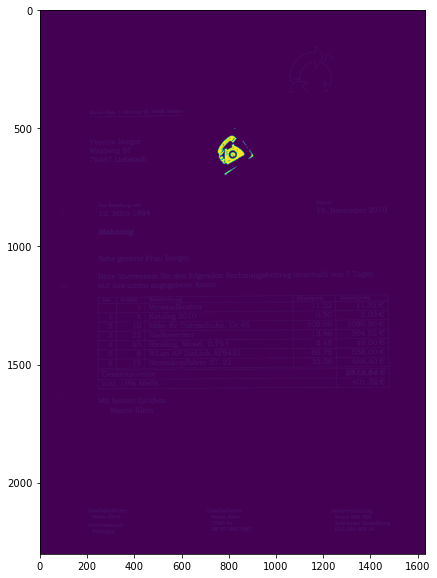

In [9]:
plt.figure(figsize=(12,10))
y = demo[2].reshape((2302, 1632)).detach().cpu()
plt.imshow(y)

In [7]:
from train import Trainer

train = (scan_files_train, truth_files_train)
val = (scan_files_val, truth_files_val)
trainer = Trainer(train, val, model, batch_size=1, epochs=100, lr=1e-2, step_size=100)

Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv
Initialize Bathch
Initialize conv


In [ ]:
trainer()

In [ ]:
demo = next(iter(train_loader))
x = demo[0].float().to(device)
output = model(x)

In [ ]:
o = output[0].permute(1,2,0).squeeze().cpu().detach().numpy()
o = np.round(o)
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(o)

y = demo[1][0].reshape(2302,1632).cpu().detach().numpy()
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(y)

### Evaluation on Test set

In [ ]:
from imageio import imread
from tqdm import tqdm
from torch.autograd import Variable

In [ ]:
steps=len(scan_files_test)
rows = 1
plt.figure(figsize=(steps*10, 10))

for i in range(steps):
    plt.subplot(1,steps,i+1)
    plt.imshow(imread(scan_files_test[i]))

In [ ]:
steps=len(scan_files_test)
plt.figure(figsize=(steps*10, 10))
predicted = []
for i, img in enumerate(tqdm(test_loader), 0):
    img = Variable(img.float()).to(device)
    output = model(img)
    output = output[0].permute(1,2,0).squeeze().cpu().detach().numpy()
    output = np.round(output)
    predicted.append(output)
    plt.subplot(1, steps, i+1)
    plt.imshow(output)